In [9]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import pickle

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models
from sklearn.preprocessing import StandardScaler

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [11]:
import PIL
print(PIL.__version__)

11.0.0


In [12]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),  
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
])

import torchvision
import torchvision.transforms as transforms

# Загружаем тренировочный и тестовый наборы CIFAR-10
trainset = torchvision.datasets.CIFAR10(
    root='./data2',
    train=True,
    download=True,
    transform=transform_train  
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,  
    num_workers=2  
)

testset = torchvision.datasets.CIFAR10(
    root='./data2',
    train=False,
    download=True,
    transform=transform_test  
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False, 
)


data_iter = iter(trainloader)
images, labels = next(data_iter)

print(f"Форма изображений: {images.shape}")  
print(f"Форма меток: {labels.shape}")  

Files already downloaded and verified
Files already downloaded and verified
Форма изображений: torch.Size([64, 3, 224, 224])
Форма меток: torch.Size([64])


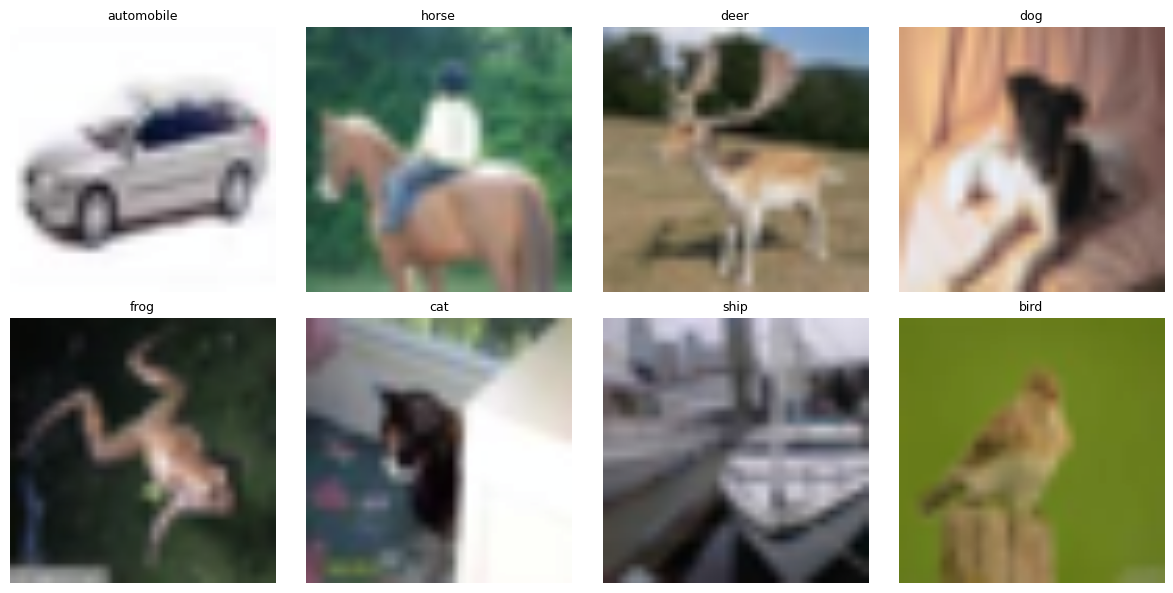

In [27]:
#Посмотрим как выглядит датасет
classes = trainset.classes 

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))  # Меняем оси с (C, H, W) -> (H, W, C) для отображения
    img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # Разнормализуем
    img = np.clip(img, 0, 1)  # Ограничиваем значения в диапазоне [0, 1]
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=9)
    plt.axis('off')

data_iter = iter(trainloader)
images, labels = next(data_iter)


plt.figure(figsize=(12, 6))
for idx in range(8):  
    plt.subplot(2, 4, idx + 1) 
    imshow(images[idx], title=classes[labels[idx]])  
plt.tight_layout()
plt.show()

In [14]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

/home/rosneft/projects/pr4/venv4/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rosneft/projects/pr4/venv4/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# Выключим обучение сверточной части
for param in vgg16.parameters():
  param.requires_grad = False

in_features = 25088 # Столько признаков идет на вход классификатору 

vgg16.classifier = torch.nn.Identity() # Убираем последний слой

In [16]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
# Функция для извлечения признаков

def extract_features(data_loader, model, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, label in data_loader:
            inputs = inputs.to(device)
            output = model(inputs)
            features.append(output.cpu().numpy())
            labels.append(label.numpy())
    return np.vstack(features), np.concatenate(labels)

In [18]:
torch.cuda.empty_cache()

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

In [21]:
# Извлечение признаков
X_train, y_train = extract_features(trainloader, vgg16, device)
X_test, y_test = extract_features(testloader, vgg16, device)

In [22]:
X_train.shape

(50000, 25088)

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import optuna

def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 32)  
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)  
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)  

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  

In [25]:
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=10)  

print(f"Лучшие параметры: {study.best_params}")
print(f"Лучшая точность: {study.best_value:.4f}")

[I 2025-01-04 18:49:25,925] A new study created in memory with name: no-name-7c079f36-e16c-43de-bec6-04579756e6f7
[I 2025-01-04 18:57:50,743] Trial 0 finished with value: 0.4851 and parameters: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.4851.
[I 2025-01-04 19:06:34,442] Trial 1 finished with value: 0.4824 and parameters: {'max_depth': 29, 'min_samples_split': 10, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.4851.
[I 2025-01-04 19:15:07,303] Trial 2 finished with value: 0.4695 and parameters: {'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4851.
[I 2025-01-04 19:23:04,490] Trial 3 finished with value: 0.4801 and parameters: {'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.4851.
[I 2025-01-04 19:29:46,761] Trial 4 finished with value: 0.4532 and parameters: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 19}. Best

Лучшие параметры: {'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 16}
Лучшая точность: 0.4851


In [26]:
best_params = study.best_params
final_model = DecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42
)

final_model.fit(X_train, y_train)

final_y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Финальная точность на тестовых данных: {final_accuracy:.4f}")

Финальная точность на тестовых данных: 0.4851
